# 巡回セールスマン問題

巡回セールスマン問題（Traveling Salesperson Problem (TSP)）とは、都市の集合と都市間の移動コストが与えられたとき、全ての都市をちょうど一度ずつ訪れて出発地に戻る閉路で、移動コストの総和が最小となるようなものを求める問題です。

応用例としては、配達員が複数の住宅を訪問する際の最適な順序を求める問題などがあります。

↓ 巡回セールスマン問題のイメージ図  
![TSP](./assets/tsp_topimage.png)


巡回セールスマン問題を数理最適化で解く方法はいくつかありますが、ここでは二次割り当て問題として定式化し、JijZeptで解く方法を紹介します。

## 二次割り当て問題としての定式化

巡回セールスマン問題は、都市$i$から都市$j$に移動する際のコストを$d_{ij}$としたとき、そのコストを元に最小距離となる巡回路（tour）を求める問題として定式化できます。

つまり決定変数は巡回路を表すように設計する必要があります。ここでは都市$i$を順序$t$番目に回るときに1、そうでないときに0とする変数$x_{it}$を導入します。

$$
x_{i,t} = \begin{cases}
1~\text{the salesman visits $t$-th city $i$,}\\
0~\text{otherwise}\\
\end{cases}
$$

このとき、決定変数が巡回路を表現するには、以下の制約条件が必要です。

### 制約条件

1. 全ての都市をちょうど一度ずつ訪れる
$$
\sum_{t=1}^{N} x_{it} = 1, \quad \forall i
$$

2. 同じ都市には2回以上訪れない
$$
\sum_{i=1}^{N} x_{it} = 1, \quad \forall t
$$


![](../assets/tsp_variable.png)

### 目的関数

目的関数は、全ての都市を訪れるためのコストを最小化するように設計します。

$$
\sum_{i,j,t} d_{i, j}x_{i, t}x_{j, (t+1)\mod N}
$$

ただし、$N$は都市の数です。"$\mod N$" によって経路の最後の都市から最初の都市に戻るときの距離を考慮しています。

## JijModelingでのモデリング

In [25]:
import jijmodeling as jm

# define variables
d = jm.Placeholder('d', ndim=2)
N = d.len_at(0, latex="N")
i = jm.Element('i', belong_to=(0, N))
j = jm.Element('j', belong_to=(0, N))
t = jm.Element('t', belong_to=(0, N))
x = jm.BinaryVar('x', shape=(N, N))

In [26]:
# set problem
problem = jm.Problem('TSP')
problem += jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", x[:, t].sum() == 1, forall=t)
problem += jm.Constraint("one-time", x[i, :].sum() == 1, forall=i)

In [27]:
problem

## データの用意

回セールスマン問題のデータとして、都市の座標を用意します。ここでは、ランダムに生成した都市の座標を使用します。

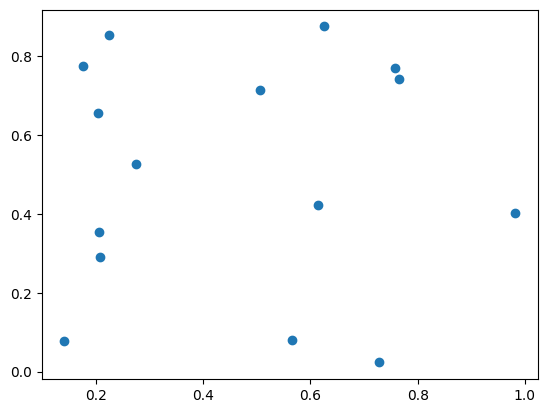

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def tsp_distance(n: int):
    """
    Args:
        n (int): number of cities
    Returns:
        tuple[np.ndarray, tuple[np.ndarray, np.ndarray]]: distance matrix, (position x, position y)
    """
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    XX, YY = np.meshgrid(x, y)
    distance = np.sqrt((XX - XX.T)**2 + (YY - YY.T)**2)
    return distance, (x, y)


num_city = 15
distance, XY = tsp_distance(num_city)
plt.scatter(*XY)
plt.show()

## JijZeptを使って最適化問題を解く

JijZeptを使って最適化問題を解いてみましょう。

In [53]:
import jijzept as jz


def solve_tsp(distance, problem):

    instance_data = {"d": distance}

    # set sampler
    sampler = jz.JijSASampler(config="config.toml")
    parameters = jz.JijSAParameters(num_reads=100, num_sweeps=2000)
    # solve problem
    response = sampler.sample_model(problem, instance_data, parameters=parameters, search=True)

    results = response.get_sampleset()

    feas_results = results.feasibles()
    print("Number of all Solutions: ", len(results))
    print("Number of Feasible Solutions: ", len(feas_results))

    lowest_solution = feas_results.lowest()
    x_value = lowest_solution[0].var_values['x'].values

    tour = np.zeros(num_city+1, dtype=int)
    for _i, t in x_value.keys():
        tour[t] = _i
    tour[-1] = tour[0]
    return tour, lowest_solution

tour, lowest_solution = solve_tsp(distance, problem)

Number of all Solutions:  1500
Number of Feasible Solutions:  1445


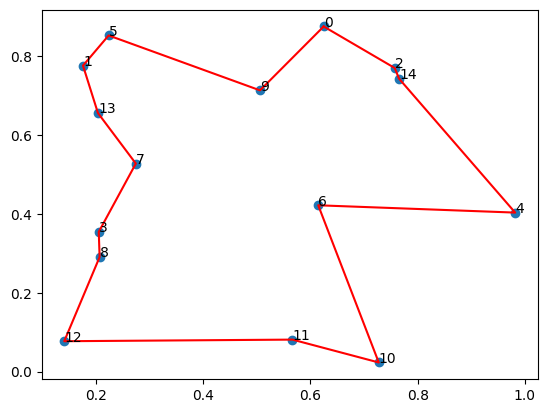

In [54]:
def plot_tour(tour, XY):
    # Plot tour
    plt.scatter(*XY)
    plt.plot(XY[0][tour], XY[1][tour], 'r-')
    # labeling the cities
    for _i, (_x, _y) in enumerate(zip(*XY)):
        plt.text(_x, _y, str(_i))
plot_tour(tour, XY)
plt.show()

In [55]:
print("Objective:", lowest_solution[0].eval.objective)

Objective: 3.32869809577184
